In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
import pickle
import os
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

In [58]:
df = pd.read_csv("TransformedData.csv")
df['Posted Time'] = pd.to_datetime(df['Posted Time'], format="%d/%m/%Y")
print(df.head())

  Posted Time     Width    Length  Floors  Rooms  Toilets  Price per m2  \
0  2025-01-31  2.236068  4.472136     0.0    0.0      0.0      1.252763   
1  2025-02-01  2.236068  4.472136     0.0    0.0      0.0      1.252763   
2  2025-01-13  2.236068  3.872983     0.0    0.0      0.0      1.554630   
3  2025-02-07  2.236068  5.477226     0.0    0.0      0.0      1.311683   
4  2025-02-02  2.236068  4.472136     0.0    0.0      0.0      1.791759   

   1 Part Residential  All Residential  Back Expansion  ...  \
0                   1                0               1  ...   
1                   0                0               1  ...   
2                   0                0               0  ...   
3                   1                0               0  ...   
4                   0                0               1  ...   

   House Direction_SOUTHWEST  House Direction_WEST  \
0                        0.0                   0.0   
1                        0.0                   1.0   
2       

In [59]:
df['year'] = df['Posted Time'].dt.year
df['month'] = df['Posted Time'].dt.month
df['day'] = df['Posted Time'].dt.day
df['dayofweek'] = df['Posted Time'].dt.dayofweek
df['quarter'] = df['Posted Time'].dt.quarter

# Cyclical features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dayOfWeek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayOfWeek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

df.drop(columns=['Posted Time'], inplace=True)

In [60]:
# Cell 3: Split data
y = df['Price per m2']
X = df.drop('Price per m2', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

X_train: (12431, 45), X_test: (3108, 45)


In [61]:
# Cell 4: Train a basic Random Forest model
print("\nTraining basic Random Forest model...")
basic_rf = RandomForestRegressor(n_estimators=100, random_state=42)
basic_rf.fit(X_train, y_train)


Training basic Random Forest model...


RandomForestRegressor(random_state=42)

In [62]:
# Evaluate on Training Set
y_train_pred = basic_rf.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate on Test Set
y_test_pred = basic_rf.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("=== Basic Random Forest Evaluation ===")
print(f"Training MSE: {mse_train:.5f}, RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, R2: {r2_train:.5f}")
print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, R2: {r2_test:.5f}")

=== Basic Random Forest Evaluation ===
Training MSE: 0.01479, RMSE: 0.12161, MAE: 0.08550, R2: 0.94852
Test MSE: 0.08814, RMSE: 0.29689, MAE: 0.21567, R2: 0.69584


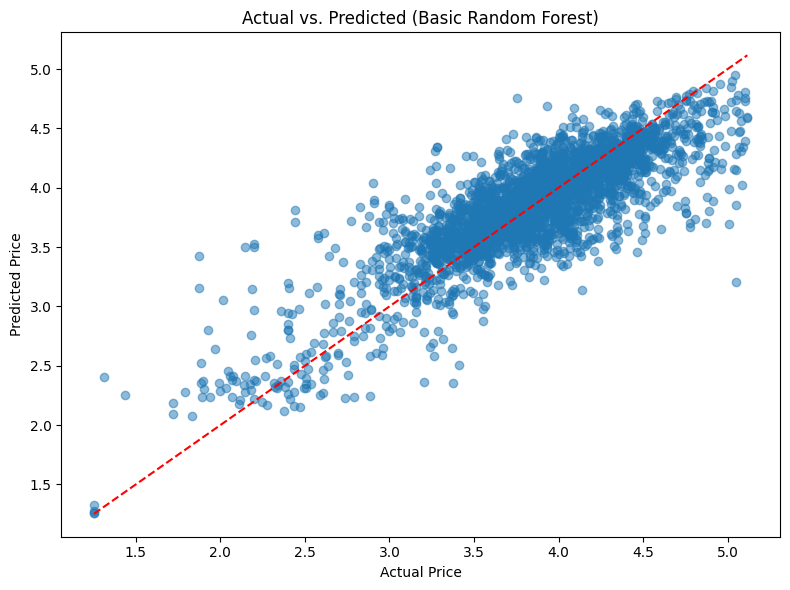

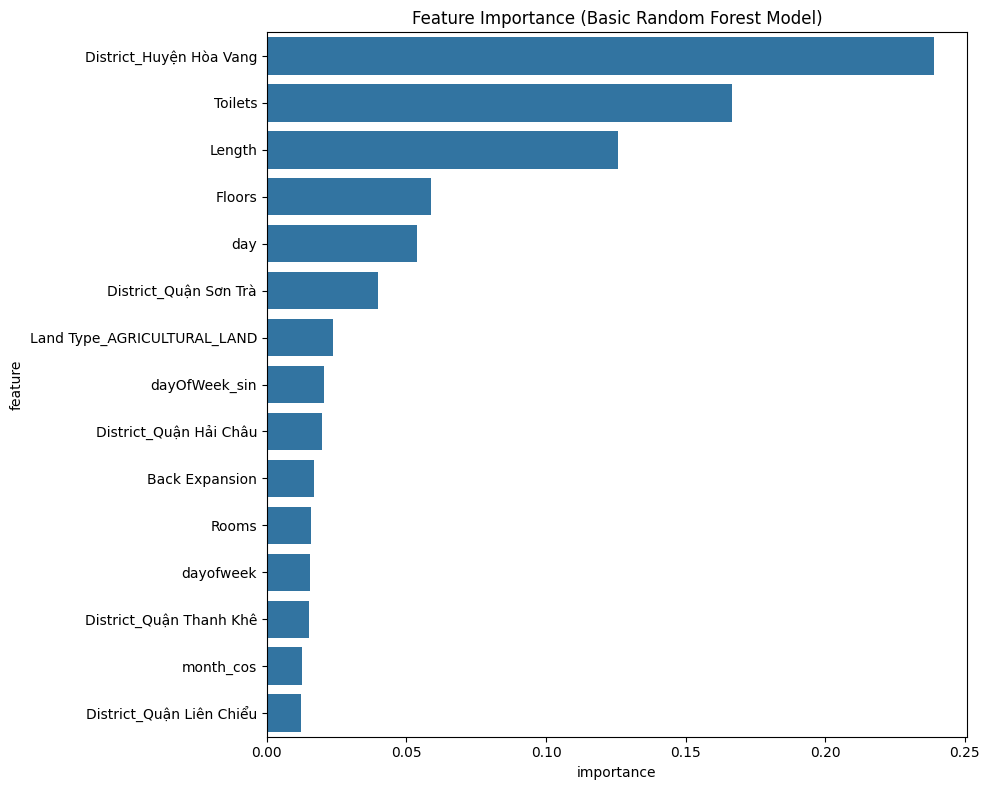

In [63]:
# Cell 5: Visualize basic model results
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted (Basic Random Forest)")
plt.tight_layout()
plt.show()
plt.close()

# Feature importance
plt.figure(figsize=(10,8))
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': basic_rf.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title("Feature Importance (Basic Random Forest Model)")
plt.tight_layout()
plt.show()
plt.close()

In [64]:
# Cell 6: Hyperparameter tuning with Grid Search
print("\nPerforming GridSearchCV for Random Forest...")
# Smaller parameter grid for demonstration
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

param_grid = {
    'n_estimators': [300],
    'max_depth': [15],
    'min_samples_split': [5],
    'min_samples_leaf': [2]
}

rf = RandomForestRegressor(random_state=42)
grid = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
# {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


Performing GridSearchCV for Random Forest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}



=== Random Forest Model Evaluation ===
Training MSE: 0.05197, RMSE: 0.22797, MAE: 0.16075, R2: 0.8191
Test MSE: 0.08547, RMSE: 0.29236, MAE: 0.21350, R2: 0.7050


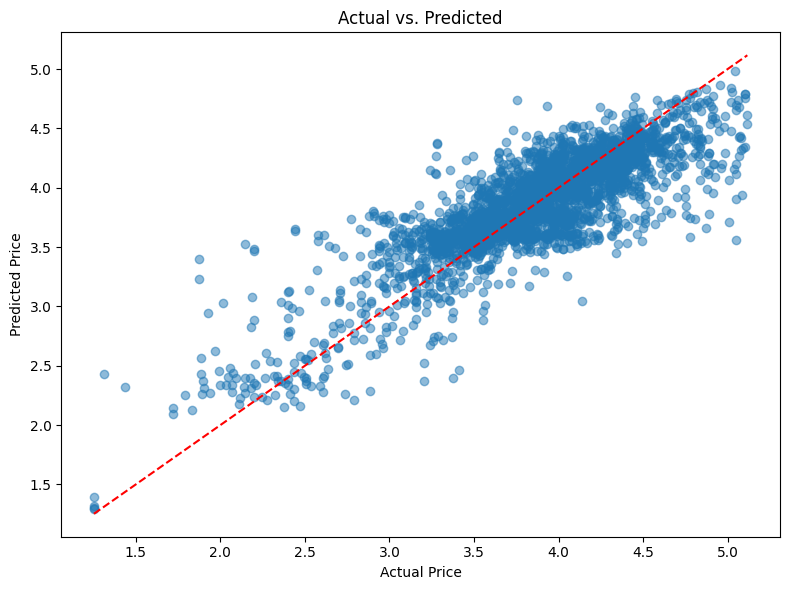

In [65]:
# Cell 7: Evaluate the best model
best_model = grid.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\n=== Random Forest Model Evaluation ===")
print(f"Training MSE: {mse_train:.5f}, RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, R2: {r2_train:.4f}")
print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, R2: {r2_test:.4f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted")
plt.tight_layout()
plt.show()
plt.close()

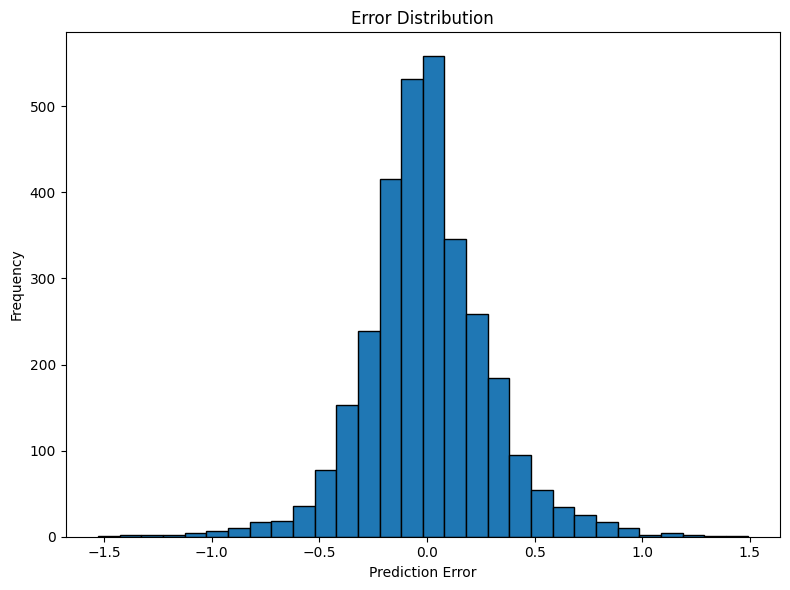


Cross-val MSE mean: 0.09464, std: 0.00368


In [66]:
# Cell 8: Error analysis
errors = y_test - y_test_pred
plt.figure(figsize=(8,6))
plt.hist(errors, bins=30, edgecolor='k')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.tight_layout()
plt.show()
plt.close()

cv_scores = cross_val_score(
    best_model, X_train, y_train,
    cv=5, scoring='neg_mean_squared_error'
)
print("\nCross-val MSE mean: {:.5f}, std: {:.5f}".format(-cv_scores.mean(), cv_scores.std()))

In [67]:
final_rf_model = RandomForestRegressor(**grid.best_params_, random_state=42)
final_rf_model.fit(X, y)

RandomForestRegressor(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=300, random_state=42)

In [68]:
pipeline = PMMLPipeline([
    ("regressor", final_rf_model)
])

output_dir = '../../Backend/src/main/resources/'
os.makedirs(output_dir, exist_ok=True)

with open('random_forest_final_model.pmml', 'wb') as f:
    pickle.dump(pipeline, f)

pmml_path = os.path.join(output_dir, 'random_forest_final_model.pmml')
sklearn2pmml(pipeline, pmml_path)

with open('random_forest_final_model.pkl', 'wb') as f:
    pickle.dump(final_rf_model, f)

pkl_path = os.path.join(output_dir, 'random_forest_final_model.pkl')
with open(pkl_path, 'wb') as f:
    pickle.dump(final_rf_model, f)


Generating 90-day forecast...


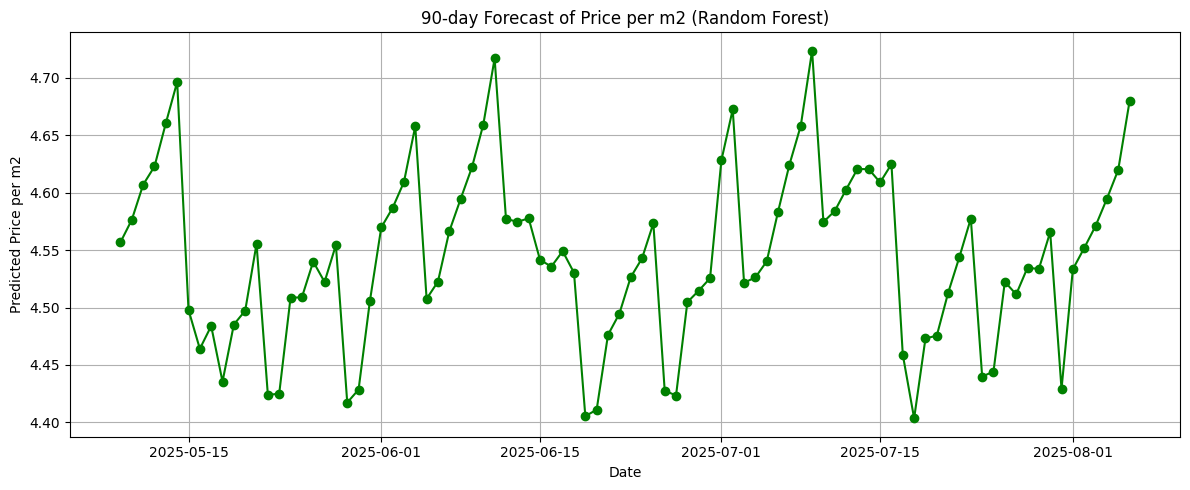

In [69]:
# Cell 10: Generate 90-day forecast
print("\nGenerating 90-day forecast...")
# Get baseline (latest sample)
base = X.iloc[-1].copy()

# Start date for forecasting (today)
start_date = pd.Timestamp.now().normalize()

# Generate forecasts
results = []
for i in range(90):
    date = start_date + timedelta(days=i)
    f = base.copy()
    
    # Update time features
    f['year'] = date.year
    f['month'] = date.month
    f['day'] = date.day
    f['dayofweek'] = date.weekday()
    f['quarter'] = date.quarter
    
    # cyclical features
    f['month_sin'] = np.sin(2 * np.pi * date.month / 12)
    f['month_cos'] = np.cos(2 * np.pi * date.month / 12)
    f['dayOfWeek_sin'] = np.sin(2 * np.pi * f['dayofweek'] / 7)
    f['dayOfWeek_cos'] = np.cos(2 * np.pi * f['dayofweek'] / 7)
    
    # Predict
    X_pred = f.values.reshape(1, -1)
    pred_price = final_rf_model.predict(X_pred)[0]
    
    results.append({
        'Date': date,
        'RF_Predicted_Price_per_m2': pred_price
    })

forecast_df = pd.DataFrame(results)

# Save forecast results
forecast_df.to_csv('random_forest_forecast_results.csv', index=False)

# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(forecast_df['Date'], forecast_df['RF_Predicted_Price_per_m2'], marker='o', color='green')
plt.title('90-day Forecast of Price per m2 (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Predicted Price per m2')
plt.grid(True)
plt.tight_layout()
plt.show()